# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

# Read the Data Set

In [ ]:
df = pd.read_csv(path + 'GOOG.csv')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
1,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
3,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
4,2004-08-26,2.613952,2.688672,2.606729,2.687676,2.687676,142572401


In [ ]:
# Rename columns
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume']
df.head()

,Date,Open,High,Low,Close,AdjClose,Volume
0,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
1,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
3,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
4,2004-08-26,2.613952,2.688672,2.606729,2.687676,2.687676,142572401


In [ ]:
# Convert date to datetime type
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,AdjClose,Volume
Date,,,,,,
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
2004-08-26,2.613952,2.688672,2.606729,2.687676,2.687676,142572401


# Visualize Data

Text(0.5, 0, 'Date')

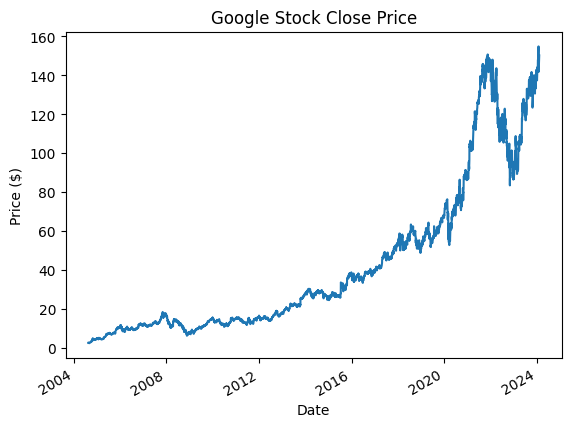

In [ ]:
# Graph close price
df.plot(y='Close', legend=False)
plt.title('Google Stock Close Price')
plt.ylabel('Price ($)')
plt.xlabel('Date')

# Prepare Data

To stabilize the variance of the data over time, we will take the log of the data.

In [ ]:
# Convert to log - Don't need to add 1 to avoid log(0) since stock prices (of interest) are positive
df['CloseLog'] = np.log(df['Close'])

Text(0.5, 0, 'Date')

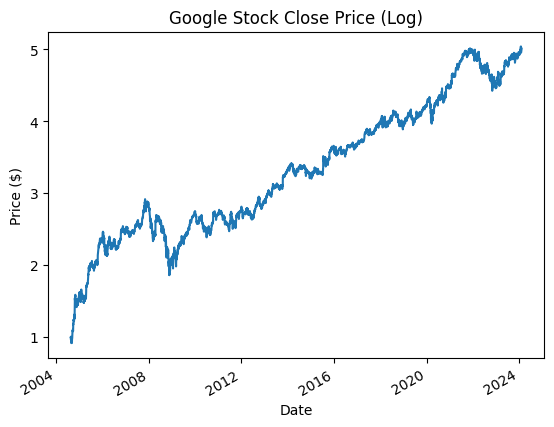

In [ ]:
# Graph close price
df.plot(y='CloseLog', legend=False)
plt.title('Google Stock Close Price (Log)')
plt.ylabel('Price ($)')
plt.xlabel('Date')

ARIMA must be used on stationary data. We will use the Augmented Dickey-Fuller (ADF) test to check for stationarity.

Let the null hypothesis $H_0$ be that the data is non-stationary and let the alternative hypothesis $H_A$ be that the data is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
result = adfuller(df['CloseLog'])

print('ADF Statistic:\t', result[0])
print('p-value:\t', result[1])
print('Critical Values:\t')
for key, value in result[4].items():
    print('\t{}: {:.3f}'.format(key, value))

ADF Statistic:	 -1.8595794086590058
p-value:	 0.3513084644375408
Critical Values:	
	1%: -3.432
	5%: -2.862
	10%: -2.567


Here, $p \approx 0.351 > 0.05$, so we cannot reject the null hypothesis and the data is non-stationary.

To make the data stationary, we can take the difference of the data and recompute the p-value.

In [ ]:
df['CloseLogDiff'] = df['CloseLog'].diff()

In [ ]:
result = adfuller(df['CloseLogDiff'].dropna())
print('ADF Statistic:\t', result[0])
print('p-value:\t', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {:.3f}'.format(key, value))

ADF Statistic:	 -30.231516486338336
p-value:	 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Now, $p = 0 < 0.05$, so we can reject the null hypothesis and the data is stationary.

Since we differenced once, we set the ARIMA parameter $d=1$

In [ ]:
# Split data
split_ratio = 0.9
split_index = int(len(df) * split_ratio)
df_train, df_test = df[:split_index], df[split_index:]

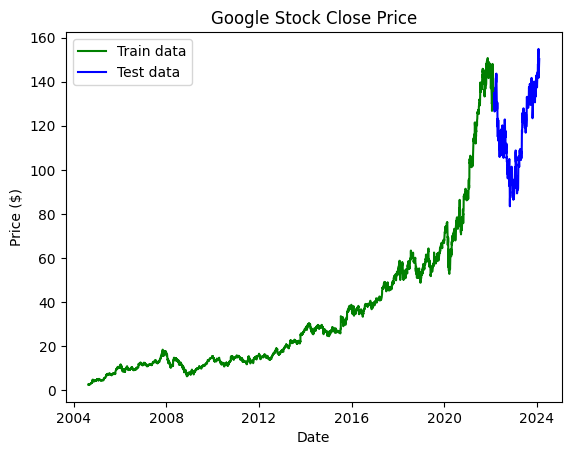

In [ ]:
# Plot train and test data
plt.plot(df_train['Close'], 'green', label='Train data')
plt.plot(df_test['Close'], 'blue', label='Test data')
plt.title('Google Stock Close Price')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.legend()

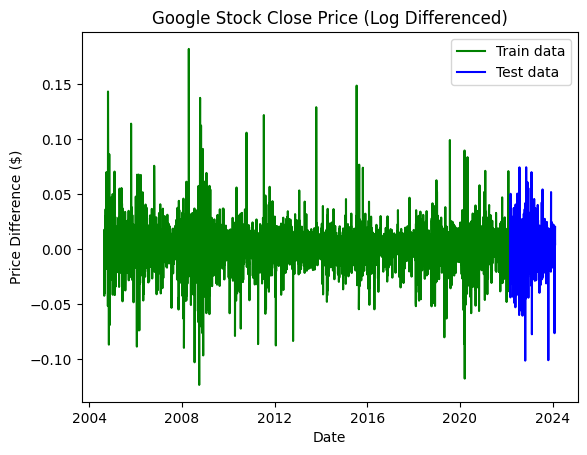

In [ ]:
# Plot train and test data
plt.plot(df_train['CloseLogDiff'], 'green', label='Train data')
plt.plot(df_test['CloseLogDiff'], 'blue', label='Test data')
plt.title('Google Stock Close Price (Log Differenced)')
plt.ylabel('Price Difference ($)')
plt.xlabel('Date')
plt.legend()

As we can see in the graph above, the data has no clear trend and oscillates around 0 (stationary). It has approximately constant variance.

The PACF graph also demonstrates that the data is stationary since we have a spike at lag-1.

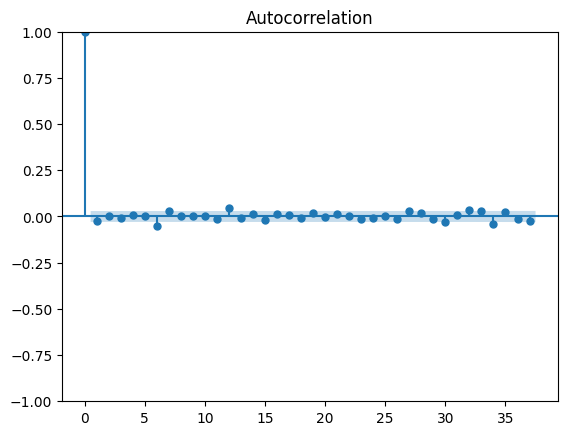

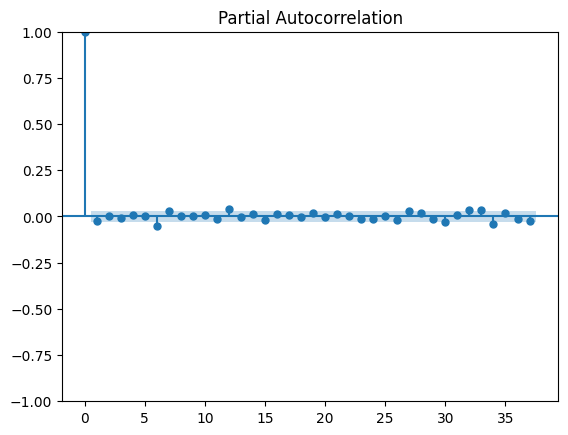

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf = plot_acf(df_train['CloseLogDiff'].dropna())
pacf = plot_pacf(df_train['CloseLogDiff'].dropna())

Using the plot again, since the PACF plot has a spike at lag-1 but not beyond, the ACF

# Fit and Evaluate Model

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
import math

In [ ]:
model_autoARIMA = auto_arima(
    df_train['CloseLog'],
    seasonal=True,
    trace=True,
    d=1
)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-22468.221, Time=5.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22473.919, Time=1.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22474.146, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-22474.125, Time=2.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22466.250, Time=0.83 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-22472.229, Time=3.80 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-22472.324, Time=2.82 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-22470.207, Time=4.48 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-22466.058, Time=0.57 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 21.907 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4411
Model:               SARIMAX(1, 1, 0)   Log Likelihood               11240.073
Date:                Tue, 26 M

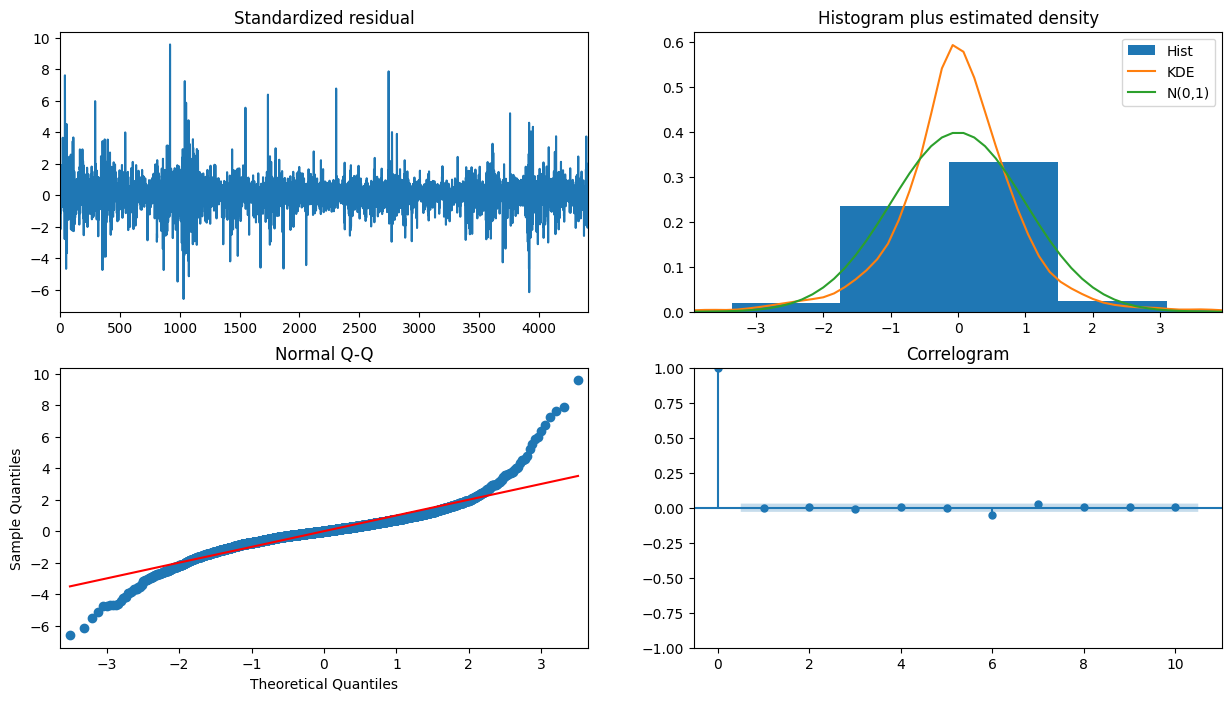

In [ ]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
best_p, best_d, best_q = model_autoARIMA.order
print("Best (p, d, q) found:", (best_p, best_d, best_q))

Best (p, d, q) found: (1, 1, 0)


In [ ]:
history = list(df_train['CloseLog'])
yhats = []

# Initialize and fit ARMIA model
for t in range(len(df_test)):
    # Fit model and predict
    model = ARIMA(history, order=(best_p, best_d, best_q))
    model_fit = model.fit()

    yhat = model_fit.forecast(steps=1)[0]
    yhats.append(yhat)

    # Add predictions and history
    true_test = df_test['CloseLog'].values[t]
    history.append(true_test)

In [ ]:
df_predictions = pd.DataFrame(yhats, columns=['PredictionLog'])
df_predictions.index = df_test.index
df_predictions.head()

,PredictionLog
Date,
2022-02-28,4.901429
2022-03-01,4.904411
2022-03-02,4.899201
2022-03-03,4.903344
2022-03-04,4.900202


In [ ]:
sum(df_predictions['PredictionLog'].isna())

0

In [ ]:
# Reverse the logarithmic scaling
def reverse_log_scaling(predictions):
    return np.exp(predictions)

In [ ]:
df_predictions['Prediction'] = reverse_log_scaling(df_predictions['PredictionLog'])
df_predictions.head()

,PredictionLog,Prediction
Date,,
2022-02-28,4.901429,134.481875
2022-03-01,4.904411,134.883485
2022-03-02,4.899201,134.182585
2022-03-03,4.903344,134.739659
2022-03-04,4.900202,134.316966


In [ ]:
df_test[['CloseLog', 'Close']].head()

,CloseLog,Close
Date,,
2022-02-28,4.904467,134.891006
2022-03-01,4.899093,134.167999
2022-03-02,4.903432,134.751495
2022-03-03,4.900136,134.307999
2022-03-04,4.883726,132.121994


In [ ]:
# Check for null entries
sum(df_test['Close'].isna()), sum(df_predictions['Prediction'].isna())

(0, 0)

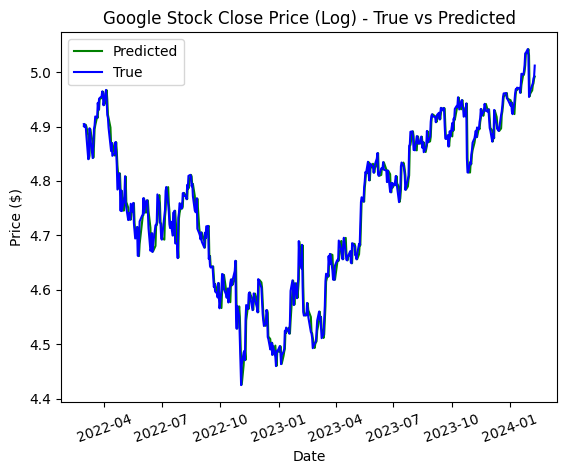

In [ ]:
# Plot predicted vs true stock price (Log)
plt.title('Google Stock Close Price (Log) - True vs Predicted')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.plot(df_predictions['PredictionLog'], 'green', label='Predicted')
plt.plot(df_test['CloseLog'], 'blue', label='True')
plt.xticks(rotation=20)
plt.legend()

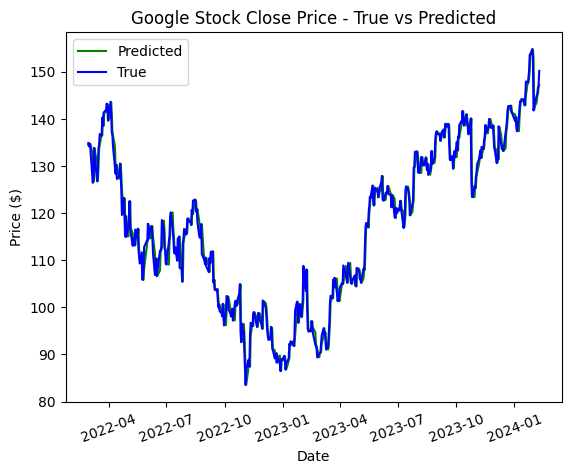

In [ ]:
# Plot predicted vs true stock price
plt.title('Google Stock Close Price - True vs Predicted')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.plot(df_predictions['Prediction'], 'green', label='Predicted')
plt.plot(df_test['Close'], 'blue', label='True')
plt.xticks(rotation=20)
plt.legend()

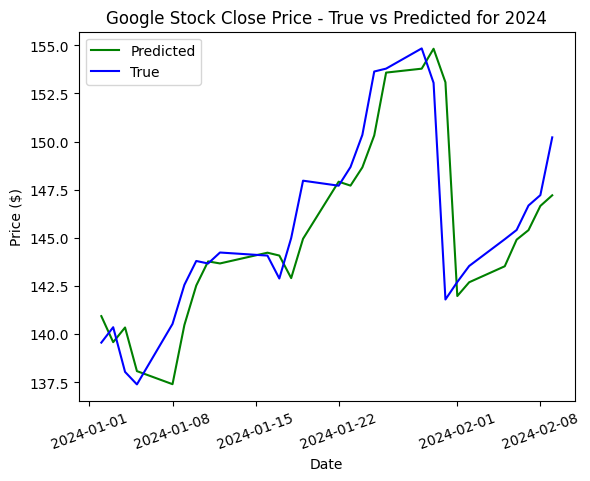

In [ ]:
plt.title('Google Stock Close Price - True vs Predicted for 2024')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.plot(df_predictions[df_predictions.index.year >= 2024]['Prediction'], 'green', label='Predicted')
plt.plot(df[df.index.year >= 2024]['Close'], 'blue', label='True')
plt.xticks(rotation=20)
plt.legend(loc='upper left')
plt.show()

As seen in the plot above, although the predictions give a somewhat low MSE, the predictions are just the true data offset by a day. Thus, this ARIMA model doesn't offer much insight into actual predictions.

In [ ]:
mse = mean_squared_error(df_test['Close'], df_predictions['Prediction'])
mae = mean_absolute_error(df_test['Close'], df_predictions['Prediction'])
rmse = math.sqrt(mean_squared_error(df_test['Close'], df_predictions['Prediction']))
print('MSE:\t', str(mse))
print('MAE:\t', str(mae))
print('RMSE:\t', str(rmse))

MSE:	 6.190329609862907
MAE:	 1.8435702852344389
RMSE:	 2.488037300737854


In [ ]:
mse = mean_squared_error(df_test['CloseLog'], df_predictions['PredictionLog'])
mae = mean_absolute_error(df_test['CloseLog'], df_predictions['PredictionLog'])
rmse = math.sqrt(mean_squared_error(df_test['CloseLog'], df_predictions['PredictionLog']))
print('MSE:\t', str(mse))
print('MAE:\t', str(mae))
print('RMSE:\t', str(rmse))

MSE:	 0.0004745004417516343
MAE:	 0.016060936462259437
RMSE:	 0.021783031050605292


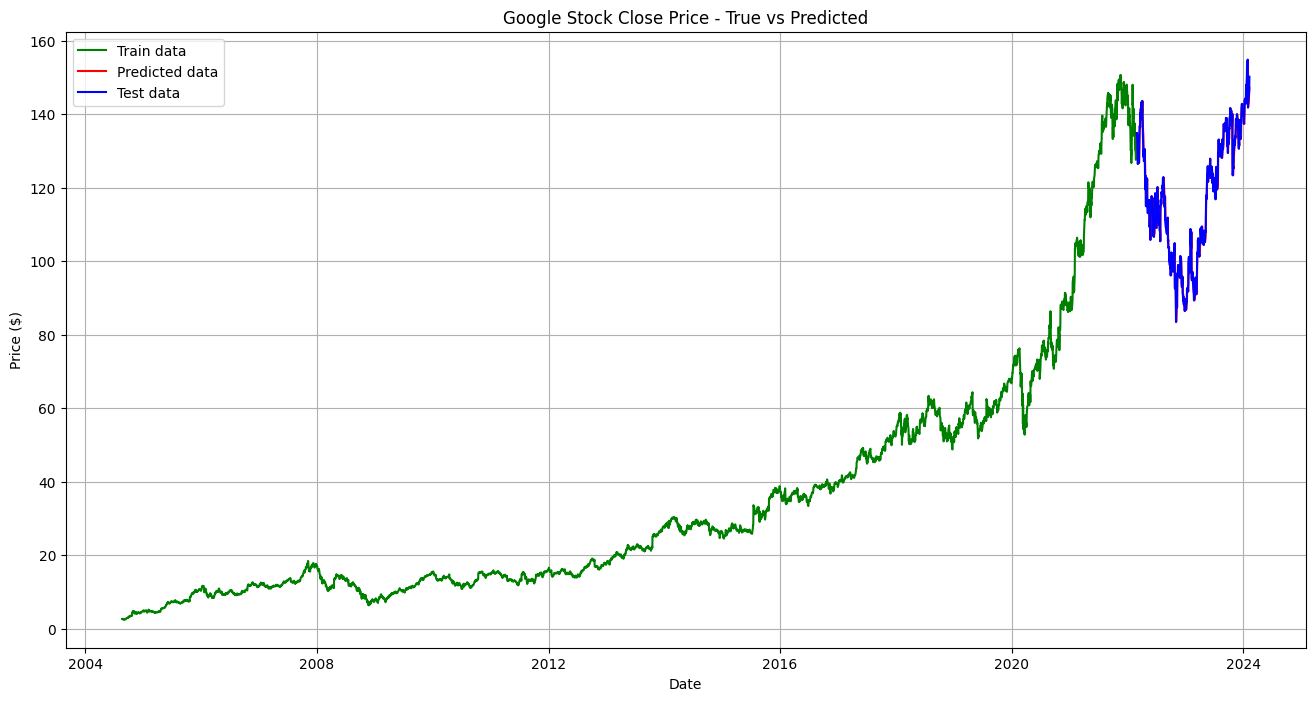

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Google Stock Close Price - True vs Predicted')
plt.plot(df_train.index, df_train['Close'], color='green', label = 'Train')
plt.plot(df_test.index, df_predictions['Prediction'], color = 'red', label = 'Predicted')
plt.plot(df_test.index, df_test['Close'], color = 'blue', label = 'Test')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()